In [31]:
import torch
import pandas as pd

In [32]:
carpark = 6

data = pd.read_csv("hf://datasets/oliverbuterbaugh/jersey-carpark-availability/jersey-carpark-availability.csv")
data = data[data['carpark'] == carpark]
data.drop(columns='carpark', inplace=True)

len(data)

57636

In [33]:
# convert df columns to tensors
spaces = torch.tensor(data['spaces'].values, dtype=torch.float32)
prcp = torch.tensor(data['prcp'].values, dtype=torch.float32)
wspd = torch.tensor(data['wspd'].values, dtype=torch.float32)
wdir = torch.tensor(data['wdir'].values, dtype=torch.float32)
hour = torch.tensor(data['hour'].values, dtype=torch.float32)
minute = torch.tensor(data['minute'].values, dtype=torch.float32)
month = torch.tensor(data['month'].values, dtype=torch.float32)
since_holiday = torch.tensor(data['since_holiday'].values, dtype=torch.float32)
until_holiday = torch.tensor(data['until_holiday'].values, dtype=torch.float32)
weekday = torch.tensor(data['weekday'].values, dtype=torch.int64)

In [34]:
# one hot encode weekday
weekday_one_hot = torch.nn.functional.one_hot(weekday, num_classes=7).float()

In [35]:
# convert hour and minute to cyclical features
hour_sin = torch.sin(hour * 2 * torch.pi / 24)
hour_cos = torch.cos(hour * 2 * torch.pi / 24)
minute_sin = torch.sin(minute * 2 * torch.pi / 60)
minute_cos = torch.cos(minute * 2 * torch.pi / 60)

# convert month to cyclical features
month_sin = torch.sin((month - 1) * (2 * torch.pi / 12))
month_cos = torch.cos((month - 1) * (2 * torch.pi / 12))

In [36]:
# stack features into a single tensor
features = torch.stack((prcp, wspd, wdir, hour_sin, hour_cos, minute_sin, minute_cos, month_sin, month_cos, since_holiday, until_holiday), dim=1)
features = torch.cat((features, weekday_one_hot), dim=1)

In [37]:
# calculate min and max values
min_values = features.min(dim=0, keepdim=True)[0]
max_values = features.max(dim=0, keepdim=True)[0]

# normalise features
normalized_features = (features - min_values) / (max_values - min_values)

In [38]:
# combine features and target into a single dataset tensor
dataset = torch.cat((normalized_features, spaces.unsqueeze(1)), dim=1)
dataset.shape

torch.Size([57636, 19])

In [39]:
# set split ratio
split_ratio = 0.8
split_index = int(split_ratio * len(dataset))

# shuffle dataset
shuffled_indices = torch.randperm(len(dataset))

# split dataset
train_indices = shuffled_indices[:split_index]
test_indices = shuffled_indices[split_index:]

train_dataset = dataset[train_indices]
test_dataset = dataset[test_indices]

# split features and target
train_features = train_dataset[:, :-1]
train_targets = train_dataset[:, -1]

test_features = test_dataset[:, :-1]
test_targets = test_dataset[:, -1]

In [40]:
train_features.shape, train_targets.shape, test_features.shape, test_targets.shape

(torch.Size([46108, 18]),
 torch.Size([46108]),
 torch.Size([11528, 18]),
 torch.Size([11528]))

In [41]:
# set device
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
# else:
#     device = torch.device('cpu')

device = torch.device('cpu')

print('Using device:', device)

# move data to device
train_features = train_features.to(device)
train_targets = train_targets.to(device)
test_features = test_features.to(device)
test_targets = test_targets.to(device)

Using device: cpu


In [42]:
import torch.nn as nn
import torch.optim as optim

# initialise model, loss function, optimiser
class ParkingSpacePredictor(nn.Module):
    def __init__(self):
        super(ParkingSpacePredictor, self).__init__()
        self.fc1 = nn.Linear(18, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

model = ParkingSpacePredictor().to(device)
criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(), lr=3e-3)

# print parameters
sum(p.numel() for p in model.parameters() if p.requires_grad)

48129

In [43]:
import math
from torch.optim.lr_scheduler import LambdaLR

# hyperparameters
num_epochs = 200
batch_size = 128
warmup_epochs = num_epochs // 10

# learning rate scheduler with warmup and cosine decay
def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return epoch / warmup_epochs
    else:
        progress = (epoch - warmup_epochs) / (num_epochs - warmup_epochs)
        return 0.5 * (1 + math.cos(math.pi * progress))

scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

def create_batches(features, targets, batch_size):
    for i in range(0, len(features), batch_size):
        yield features[i:i+batch_size], targets[i:i+batch_size]

losses = []
val_losses = []

# training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_features, batch_targets in create_batches(train_features, train_targets, batch_size):
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs.squeeze(), batch_targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(train_features)
    losses.append(avg_epoch_loss)
    
    # val loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_features, batch_targets in create_batches(test_features, test_targets, batch_size):
            outputs = model(batch_features)
            loss = criterion(outputs.squeeze(), batch_targets)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(test_features)
    val_losses.append(avg_val_loss)
    
    # step scheduler
    scheduler.step()
    
    if (epoch) % 20 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {avg_epoch_loss:.4f}, Val Loss: {avg_val_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}')


Epoch 0/200, Loss: 2.2638, Val Loss: 2.2994, LR: 0.000150
Epoch 20/200, Loss: 0.1572, Val Loss: 0.1724, LR: 0.003000
Epoch 40/200, Loss: 0.0908, Val Loss: 0.0915, LR: 0.002900
Epoch 60/200, Loss: 0.0723, Val Loss: 0.0736, LR: 0.002632
Epoch 80/200, Loss: 0.0633, Val Loss: 0.0662, LR: 0.002227
Epoch 100/200, Loss: 0.0545, Val Loss: 0.0581, LR: 0.001735
Epoch 120/200, Loss: 0.0474, Val Loss: 0.0520, LR: 0.001214
Epoch 140/200, Loss: 0.0409, Val Loss: 0.0470, LR: 0.000727
Epoch 160/200, Loss: 0.0356, Val Loss: 0.0434, LR: 0.000334
Epoch 180/200, Loss: 0.0314, Val Loss: 0.0380, LR: 0.000082


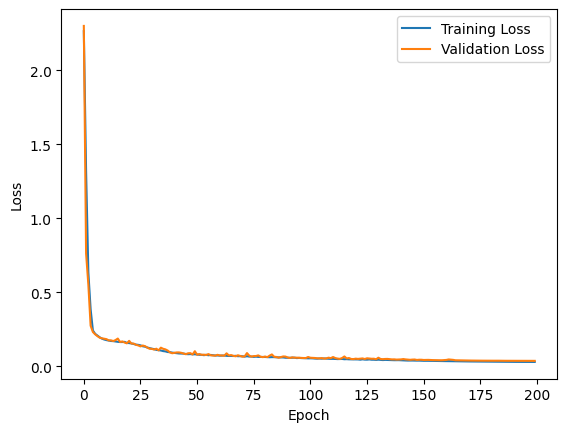

In [44]:
import matplotlib.pyplot as plt

# plot loss
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
import torch
import torch.nn.functional as F

# eval mode
model.eval()
test_loss = 0

# disable gradient calculation
with torch.no_grad():
    for batch_features, batch_targets in create_batches(test_features, test_targets, batch_size):
        outputs = model(batch_features)
        loss = criterion(outputs.squeeze(), batch_targets)
        test_loss += loss.item()

# average test loss
avg_test_loss = test_loss / len(test_features)
print(f'Test Loss: {avg_test_loss:.4f}')

# MAE
def mean_absolute_error(predictions, targets):
    return torch.mean(torch.abs(predictions - targets))

# RMSE
def root_mean_squared_error(predictions, targets):
    return torch.sqrt(torch.mean((predictions - targets) ** 2))

# R squared
def r_squared(predictions, targets):
    ss_res = torch.sum((targets - predictions) ** 2)
    ss_tot = torch.sum((targets - torch.mean(targets)) ** 2)
    return 1 - ss_res / ss_tot

# calculate
with torch.no_grad():
    test_predictions = model(test_features).squeeze()
    
    mae = mean_absolute_error(test_predictions, test_targets)
    rmse = root_mean_squared_error(test_predictions, test_targets)
    r2 = r_squared(test_predictions, test_targets)
    
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'R squared: {r2:.4f}')


Test Loss: 0.0371
MAE: 4.7207
RMSE: 9.6223
R squared: 0.9964


In [46]:
# aample a subset of the test data
num_samples = 10
sample_indices = torch.randperm(len(test_features))[:num_samples]
sample_features = test_features[sample_indices]
sample_targets = test_targets[sample_indices]

# get model predictions for the sample
model.eval()
with torch.no_grad():
    sample_predictions = model(sample_features).squeeze()


for i in range(num_samples):
    print(f"actual: {int(sample_targets[i].item())}, predicted: {int(sample_predictions[i].item())}")

actual: 23, predicted: 29
actual: 369, predicted: 365
actual: 360, predicted: 360
actual: 277, predicted: 269
actual: 0, predicted: 0
actual: 407, predicted: 405
actual: 402, predicted: 402
actual: 424, predicted: 424
actual: 16, predicted: 0
actual: 379, predicted: 382


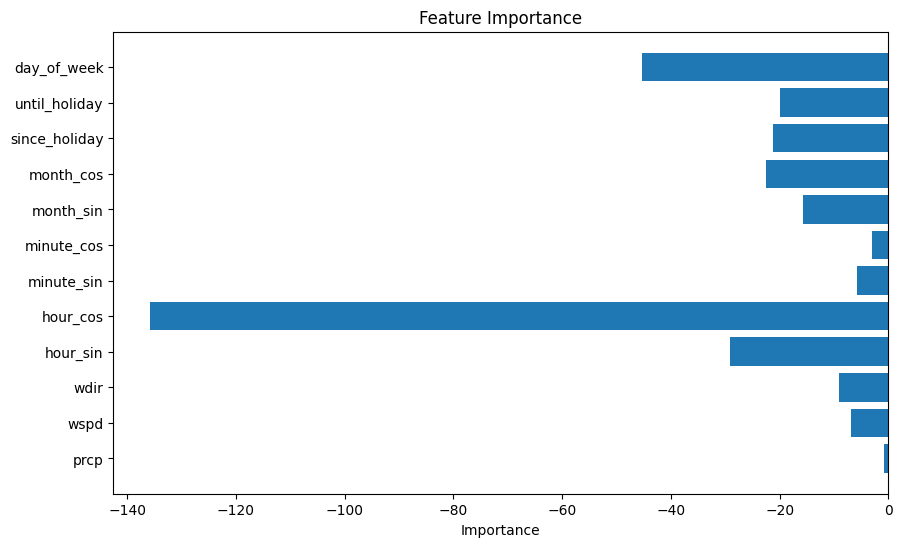

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def permutation_importance(model, features, targets, criterion, feature_groups, num_repeats=10):
    model.eval()
    baseline_loss = criterion(model(features).squeeze(), targets).item()
    feature_importances = np.zeros(len(feature_groups))
    
    for group_idx, group_features in enumerate(feature_groups):
        permuted_loss = 0.0
        for _ in range(num_repeats):
            permuted_features = features.clone()
            # Permute all features in the group simultaneously
            permuted_indices = torch.randperm(permuted_features.size(0))
            for feature_idx in group_features:
                permuted_features[:, feature_idx] = permuted_features[:, feature_idx][permuted_indices]
            with torch.no_grad():
                permuted_loss += criterion(model(permuted_features).squeeze(), targets).item()
        permuted_loss /= num_repeats
        feature_importances[group_idx] = baseline_loss - permuted_loss
    
    return feature_importances

# Define the groups of features, where each group is a list of indices
feature_groups = [
    [0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10],
    list(range(9, 16))  # This represents the one-hot encoded day_of_week
]

# Feature names now corresponding to the groups
feature_names = ['prcp', 'wspd', 'wdir', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 
                 'month_sin', 'month_cos', 'since_holiday', 'until_holiday', 'day_of_week']

# Calculate permutation importance
feature_importances = permutation_importance(model, test_features, test_targets, criterion, feature_groups)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), feature_names)
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()